In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

import nltk
nltk.download('punkt_tab')

# Ensure required nltk resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [5]:
import gzip
from tqdm import tqdm
path_to_file = "review-New_York_10.json.gz"

# Let's load all data
data = []
for i, d in tqdm(enumerate(parse(path_to_file))):  
    data.append(d)

18661975it [03:10, 97947.98it/s] 


In [6]:
df = pd.DataFrame(data)

In [7]:
import re

def remove_translated_reviews(text):
    if isinstance(text, str) and re.search(r'\(Translated by Google\)', text, re.IGNORECASE):
        return np.nan  # Mark for drop
    return text

In [8]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [9]:
df_initclean=df.drop(columns=['name', 'time', 'pics', 'resp'])
df_initclean['text']=df_initclean['text'].apply(remove_translated_reviews)
df_initclean = df_initclean.dropna()
df_initclean['text']=df_initclean['text'].apply(remove_emojis)
df_initclean.drop_duplicates(inplace=True)

In [10]:
n_per_class = 5000
# Sample equal instances per rating
df_sampled = df_initclean.groupby('rating', group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_per_class), random_state=42))
df_sampled.reset_index()
df_sampled

C:\Users\madel\AppData\Local\Temp\ipykernel_23428\2802922487.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_initclean.groupby('rating', group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_per_class), random_state=42))


,user_id,rating,text,gmap_id
1030933,108754496617711878337,1,Took us long to sit. Only one person that work...,0x89dc072685f8db8d:0x472c97602ebb781d
607821,110913657411615367606,1,I walked in ready to get my tattoo here based ...,0x89c24e6e75ae6bdb:0x62e6927a6eb3310d
2528995,101525478558822638524,1,"Really bad customer service, plus over price.",0x89c2f3f66d608019:0x134316ff67a75ae3
863351,100700392448875044171,1,They have a youg lady that works there and she...,0x89c2599e515bf4dd:0x4f079e048a26869d
347529,106010706783677566665,1,"Disgusting, came wait for 15 minutes, while th...",0x89c3291acfa48871:0x3434bc5ee5656c46
...,...,...,...,...
3524545,111804332381639835095,5,Fabulous and affordable foot massages! I fell ...,0x89c2598a1d6dee47:0xe070609e21a64634
16594990,116599168886836045412,5,"I got a Burger, and it tastes like a burger, b...",0x89de0b600d44e809:0xeb80a6444d687c33
4057474,110344283172678365745,5,"Martha's is a BROTHEL for cakes, pies, cupcake...",0x89c25e2133f979af:0xa7f358088161d74f
3344914,107594452255849902375,5,"Great fish fry. Two sizes, smaller one perfect...",0x89d3621364a519a9:0x357285d78d37321c


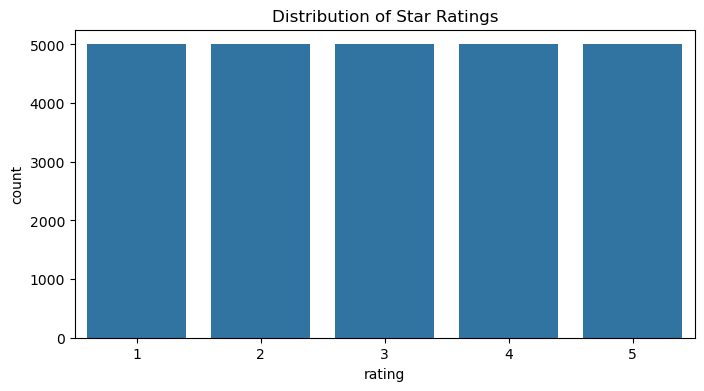

In [11]:
# EDA - double check distribution of ratings in dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of ratings
plt.figure(figsize=(8,4))
sns.countplot(data=df_sampled, x='rating', order=sorted(df_sampled['rating'].unique()))
plt.title("Distribution of Star Ratings")
plt.show()

In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)     # Remove extra whitespace
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [13]:
df_cleaned = df_sampled.copy()
df_cleaned['clean_review']=df_cleaned['text'].apply(preprocess_text)
df_cleaned

,user_id,rating,text,gmap_id,clean_review
1030933,108754496617711878337,1,Took us long to sit. Only one person that work...,0x89dc072685f8db8d:0x472c97602ebb781d,took u long sit one person worked want go like...
607821,110913657411615367606,1,I walked in ready to get my tattoo here based ...,0x89c24e6e75ae6bdb:0x62e6927a6eb3310d,walked ready get tattoo based good review reco...
2528995,101525478558822638524,1,"Really bad customer service, plus over price.",0x89c2f3f66d608019:0x134316ff67a75ae3,really bad customer service plus price
863351,100700392448875044171,1,They have a youg lady that works there and she...,0x89c2599e515bf4dd:0x4f079e048a26869d,youg lady work steal card info order phone use...
347529,106010706783677566665,1,"Disgusting, came wait for 15 minutes, while th...",0x89c3291acfa48871:0x3434bc5ee5656c46,disgusting came wait minute talk b even apolog...
...,...,...,...,...,...
3524545,111804332381639835095,5,Fabulous and affordable foot massages! I fell ...,0x89c2598a1d6dee47:0xe070609e21a64634,fabulous affordable foot massage fell asleep a...
16594990,116599168886836045412,5,"I got a Burger, and it tastes like a burger, b...",0x89de0b600d44e809:0xeb80a6444d687c33,got burger taste like burger better also known...
4057474,110344283172678365745,5,"Martha's is a BROTHEL for cakes, pies, cupcake...",0x89c25e2133f979af:0xa7f358088161d74f,marthas brothel cake pie cupcake cooky muffin ...
3344914,107594452255849902375,5,"Great fish fry. Two sizes, smaller one perfect...",0x89d3621364a519a9:0x357285d78d37321c,great fish fry two size smaller one perfect re...


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [15]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)["compound"]
    return 0

df_cleaned["sentiment_vader"] = df_cleaned["clean_review"].apply(get_sentiment_score)
df_cleaned

,user_id,rating,text,gmap_id,clean_review,sentiment_vader
1030933,108754496617711878337,1,Took us long to sit. Only one person that work...,0x89dc072685f8db8d:0x472c97602ebb781d,took u long sit one person worked want go like...,0.4215
607821,110913657411615367606,1,I walked in ready to get my tattoo here based ...,0x89c24e6e75ae6bdb:0x62e6927a6eb3310d,walked ready get tattoo based good review reco...,-0.2746
2528995,101525478558822638524,1,"Really bad customer service, plus over price.",0x89c2f3f66d608019:0x134316ff67a75ae3,really bad customer service plus price,-0.5849
863351,100700392448875044171,1,They have a youg lady that works there and she...,0x89c2599e515bf4dd:0x4f079e048a26869d,youg lady work steal card info order phone use...,-0.4939
347529,106010706783677566665,1,"Disgusting, came wait for 15 minutes, while th...",0x89c3291acfa48871:0x3434bc5ee5656c46,disgusting came wait minute talk b even apolog...,-0.4588
...,...,...,...,...,...,...
3524545,111804332381639835095,5,Fabulous and affordable foot massages! I fell ...,0x89c2598a1d6dee47:0xe070609e21a64634,fabulous affordable foot massage fell asleep a...,0.8720
16594990,116599168886836045412,5,"I got a Burger, and it tastes like a burger, b...",0x89de0b600d44e809:0xeb80a6444d687c33,got burger taste like burger better also known...,0.6597
4057474,110344283172678365745,5,"Martha's is a BROTHEL for cakes, pies, cupcake...",0x89c25e2133f979af:0xa7f358088161d74f,marthas brothel cake pie cupcake cooky muffin ...,0.4215
3344914,107594452255849902375,5,"Great fish fry. Two sizes, smaller one perfect...",0x89d3621364a519a9:0x357285d78d37321c,great fish fry two size smaller one perfect re...,0.9001


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install textblob

In [25]:
from transformers import pipeline

# Load pre-trained sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def get_bert_sentiment(text):
    sentiment = sentiment_pipeline(text[:512])  # Truncate long reviews for efficiency
    score = int(sentiment[0]['label'][0])  # Extract rating (1-5)
    return score

df_cleaned['sentiment_bert'] = df_cleaned['clean_review'].apply(get_bert_sentiment)

from textblob import TextBlob

# Sentiment Analysis
df_cleaned['sentiment_textblob'] = df_cleaned['clean_review'].apply(lambda x: TextBlob(x).sentiment.polarity)


Device set to use cpu


In [27]:
df_cleaned

,user_id,rating,text,gmap_id,clean_review,sentiment_vader,sentiment_bert,sentiment_textblob
1030933,108754496617711878337,1,Took us long to sit. Only one person that work...,0x89dc072685f8db8d:0x472c97602ebb781d,took u long sit one person worked want go like...,0.4215,1,-0.050000
607821,110913657411615367606,1,I walked in ready to get my tattoo here based ...,0x89c24e6e75ae6bdb:0x62e6927a6eb3310d,walked ready get tattoo based good review reco...,-0.2746,1,-0.028571
2528995,101525478558822638524,1,"Really bad customer service, plus over price.",0x89c2f3f66d608019:0x134316ff67a75ae3,really bad customer service plus price,-0.5849,1,-0.700000
863351,100700392448875044171,1,They have a youg lady that works there and she...,0x89c2599e515bf4dd:0x4f079e048a26869d,youg lady work steal card info order phone use...,-0.4939,1,0.000000
347529,106010706783677566665,1,"Disgusting, came wait for 15 minutes, while th...",0x89c3291acfa48871:0x3434bc5ee5656c46,disgusting came wait minute talk b even apolog...,-0.4588,1,-1.000000
...,...,...,...,...,...,...,...,...
3524545,111804332381639835095,5,Fabulous and affordable foot massages! I fell ...,0x89c2598a1d6dee47:0xe070609e21a64634,fabulous affordable foot massage fell asleep a...,0.8720,5,0.200000
16594990,116599168886836045412,5,"I got a Burger, and it tastes like a burger, b...",0x89de0b600d44e809:0xeb80a6444d687c33,got burger taste like burger better also known...,0.6597,3,0.500000
4057474,110344283172678365745,5,"Martha's is a BROTHEL for cakes, pies, cupcake...",0x89c25e2133f979af:0xa7f358088161d74f,marthas brothel cake pie cupcake cooky muffin ...,0.4215,4,0.600000
3344914,107594452255849902375,5,"Great fish fry. Two sizes, smaller one perfect...",0x89d3621364a519a9:0x357285d78d37321c,great fish fry two size smaller one perfect re...,0.9001,5,0.435000


In [29]:
def bucket_sentiment(score):
    if score < -0.4: return 1
    elif score < 0: return 2
    elif score < 0.4: return 3
    elif score < 0.7: return 4
    else: return 5

In [31]:
# convert sentiments into buckets and then majority vote:
df_sentiment = df_cleaned.copy()
df_sentiment['sentiment_vader'] = df_sentiment['sentiment_vader'].apply(bucket_sentiment)
df_sentiment['sentiment_textblob'] = df_sentiment['sentiment_textblob'].apply(bucket_sentiment)
df_sentiment

,user_id,rating,text,gmap_id,clean_review,sentiment_vader,sentiment_bert,sentiment_textblob
1030933,108754496617711878337,1,Took us long to sit. Only one person that work...,0x89dc072685f8db8d:0x472c97602ebb781d,took u long sit one person worked want go like...,4,1,2
607821,110913657411615367606,1,I walked in ready to get my tattoo here based ...,0x89c24e6e75ae6bdb:0x62e6927a6eb3310d,walked ready get tattoo based good review reco...,2,1,2
2528995,101525478558822638524,1,"Really bad customer service, plus over price.",0x89c2f3f66d608019:0x134316ff67a75ae3,really bad customer service plus price,1,1,1
863351,100700392448875044171,1,They have a youg lady that works there and she...,0x89c2599e515bf4dd:0x4f079e048a26869d,youg lady work steal card info order phone use...,1,1,3
347529,106010706783677566665,1,"Disgusting, came wait for 15 minutes, while th...",0x89c3291acfa48871:0x3434bc5ee5656c46,disgusting came wait minute talk b even apolog...,1,1,1
...,...,...,...,...,...,...,...,...
3524545,111804332381639835095,5,Fabulous and affordable foot massages! I fell ...,0x89c2598a1d6dee47:0xe070609e21a64634,fabulous affordable foot massage fell asleep a...,5,5,3
16594990,116599168886836045412,5,"I got a Burger, and it tastes like a burger, b...",0x89de0b600d44e809:0xeb80a6444d687c33,got burger taste like burger better also known...,4,3,4
4057474,110344283172678365745,5,"Martha's is a BROTHEL for cakes, pies, cupcake...",0x89c25e2133f979af:0xa7f358088161d74f,marthas brothel cake pie cupcake cooky muffin ...,4,4,4
3344914,107594452255849902375,5,"Great fish fry. Two sizes, smaller one perfect...",0x89d3621364a519a9:0x357285d78d37321c,great fish fry two size smaller one perfect re...,5,5,4


In [33]:
from collections import Counter
import statistics

def majority_vote_sentiment(scores):
    if not scores:
        return None

    # Count the frequency of each score
    counter = Counter(scores)
    most_common = counter.most_common()
    
    # Check for majority
    top_freq = most_common[0][1]
    top_scores = [score for score, freq in most_common if freq == top_freq]

    if len(top_scores) == 1:
        return top_scores[0]  # Unique majority
    else:
        return statistics.median(top_scores)  # Tie -> fallback to median

df_sentiment['final_sentiment'] = df_sentiment.apply(lambda row: majority_vote_sentiment([row['sentiment_vader'],
                                                                      row['sentiment_textblob'],
                                                                      row['sentiment_bert']]), axis=1)

df_sentiment


,user_id,rating,text,gmap_id,clean_review,sentiment_vader,sentiment_bert,sentiment_textblob,final_sentiment
1030933,108754496617711878337,1,Took us long to sit. Only one person that work...,0x89dc072685f8db8d:0x472c97602ebb781d,took u long sit one person worked want go like...,4,1,2,2
607821,110913657411615367606,1,I walked in ready to get my tattoo here based ...,0x89c24e6e75ae6bdb:0x62e6927a6eb3310d,walked ready get tattoo based good review reco...,2,1,2,2
2528995,101525478558822638524,1,"Really bad customer service, plus over price.",0x89c2f3f66d608019:0x134316ff67a75ae3,really bad customer service plus price,1,1,1,1
863351,100700392448875044171,1,They have a youg lady that works there and she...,0x89c2599e515bf4dd:0x4f079e048a26869d,youg lady work steal card info order phone use...,1,1,3,1
347529,106010706783677566665,1,"Disgusting, came wait for 15 minutes, while th...",0x89c3291acfa48871:0x3434bc5ee5656c46,disgusting came wait minute talk b even apolog...,1,1,1,1
...,...,...,...,...,...,...,...,...,...
3524545,111804332381639835095,5,Fabulous and affordable foot massages! I fell ...,0x89c2598a1d6dee47:0xe070609e21a64634,fabulous affordable foot massage fell asleep a...,5,5,3,5
16594990,116599168886836045412,5,"I got a Burger, and it tastes like a burger, b...",0x89de0b600d44e809:0xeb80a6444d687c33,got burger taste like burger better also known...,4,3,4,4
4057474,110344283172678365745,5,"Martha's is a BROTHEL for cakes, pies, cupcake...",0x89c25e2133f979af:0xa7f358088161d74f,marthas brothel cake pie cupcake cooky muffin ...,4,4,4,4
3344914,107594452255849902375,5,"Great fish fry. Two sizes, smaller one perfect...",0x89d3621364a519a9:0x357285d78d37321c,great fish fry two size smaller one perfect re...,5,5,4,5


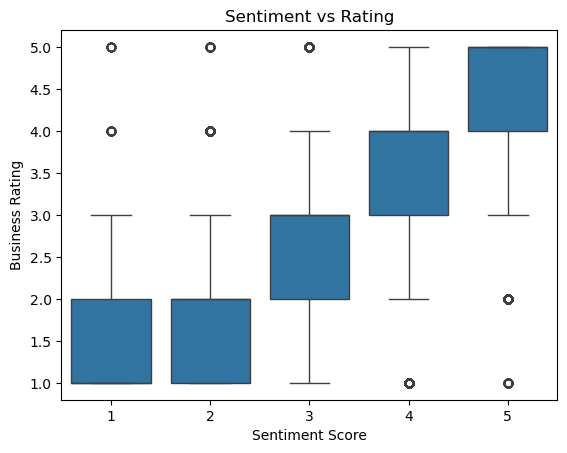

         count    mean       std  min  25%  50%  75%  max
rating                                                   
1       5000.0  2.0664  1.009056  1.0  1.0  2.0  3.0  5.0
2       5000.0  2.6200  1.021474  1.0  2.0  3.0  3.0  5.0
3       5000.0  3.2616  0.907375  1.0  3.0  3.0  4.0  5.0
4       5000.0  3.9898  0.825731  1.0  4.0  4.0  5.0  5.0
5       5000.0  4.3904  0.772339  1.0  4.0  5.0  5.0  5.0


In [85]:
# Plot sentiment scores vs ratings
sns.boxplot(x='final_sentiment', y='rating', data=df_sentiment)
plt.xlabel('Sentiment Score')
plt.ylabel('Business Rating')
plt.title('Sentiment vs Rating')
plt.show()

# Check summary statistics for sentiment scores grouped by ratings
print(df_sentiment.groupby('rating')['final_sentiment'].describe())

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack
import numpy as np

# Split
X_train_text, X_test_text, y_train, y_test, X_train_sent, X_test_sent = train_test_split(
    df_sentiment['clean_review'],
    df_sentiment['rating'],
    df_sentiment['final_sentiment'].values.reshape(-1, 1),  # Reshape for stacking
    test_size=0.2,
    stratify=df_sentiment['rating'],
    random_state=42
)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Combine TF-IDF with sentiment
X_train_combined = hstack([X_train_tfidf, X_train_sent])
X_test_combined = hstack([X_test_tfidf, X_test_sent])

# Model - logistic regression
clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_combined, y_train)

# Evaluation
preds = clf_tfidf.predict(X_test_combined)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           1       0.59      0.63      0.61      1000
           2       0.42      0.40      0.41      1000
           3       0.40      0.39      0.40      1000
           4       0.41      0.38      0.40      1000
           5       0.56      0.60      0.58      1000

    accuracy                           0.48      5000
   macro avg       0.48      0.48      0.48      5000
weighted avg       0.48      0.48      0.48      5000



In [45]:
# random forest

from sklearn.ensemble import RandomForestClassifier
clf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_tfidf.fit(X_train_combined, y_train)

# Evaluation
preds = clf_tfidf.predict(X_test_combined)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           1       0.51      0.69      0.58      1000
           2       0.41      0.31      0.35      1000
           3       0.39      0.33      0.35      1000
           4       0.41      0.37      0.39      1000
           5       0.54      0.62      0.58      1000

    accuracy                           0.46      5000
   macro avg       0.45      0.46      0.45      5000
weighted avg       0.45      0.46      0.45      5000



In [51]:
from xgboost import XGBClassifier
clf_tfidf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf_tfidf.fit(X_train_combined, (y_train-1))

# Evaluation
preds = clf_tfidf.predict(X_test_combined)
print(classification_report((y_test-1), preds))


C:\Users\madel\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:31:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.60      0.59      0.59      1000
           1       0.39      0.36      0.37      1000
           2       0.36      0.36      0.36      1000
           3       0.40      0.41      0.40      1000
           4       0.58      0.60      0.59      1000

    accuracy                           0.47      5000
   macro avg       0.47      0.47      0.47      5000
weighted avg       0.47      0.47      0.47      5000



In [53]:
from sklearn.naive_bayes import MultinomialNB
clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_combined, (y_train-1))

# Evaluation
preds = clf_tfidf.predict(X_test_combined)
print(classification_report((y_test-1), preds))

              precision    recall  f1-score   support

           0       0.63      0.56      0.60      1000
           1       0.43      0.32      0.36      1000
           2       0.42      0.34      0.38      1000
           3       0.38      0.42      0.40      1000
           4       0.48      0.69      0.57      1000

    accuracy                           0.47      5000
   macro avg       0.47      0.47      0.46      5000
weighted avg       0.47      0.47      0.46      5000



In [67]:
# Dataset and DataLoader
class ReviewDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

X_train_tensor = torch.tensor(X_train_combined.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_combined.toarray(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)  # Assuming ratings 1–5
y_test_tensor = torch.tensor(y_test.values - 1, dtype=torch.long)

train_dataset = ReviewDataset(X_train_tensor, y_train_tensor)
test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [69]:
# Define a BiLSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

In [71]:
# Model training
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            #loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")
        model.eval()
        for inputs, labels in test_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            #loss = criterion(outputs, labels)
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {total_loss/len(train_loader)}")

In [63]:
# Initialize model
input_size = train_tensor.shape[1]
num_classes = 5
model = RatingPredictor(input_size, num_classes)

# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train model
train_model(model, train_loader, test_loader, criterion, optimizer)

NameError: name 'train_tensor' is not defined

In [73]:
# Initialize model
input_size = X_train_combined.shape[1]
# num_classes = 5
num_classes = 5
model = BiLSTMModel(input_size, hidden_size=128, num_layers=2, num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train model
train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/30, Loss: 1.4497534299850463
Epoch 1/30, Val Loss: 1.767132409286499
Epoch 2/30, Loss: 1.2300498495101928
Epoch 2/30, Val Loss: 1.5377036797523498
Epoch 3/30, Loss: 1.18332288274765
Epoch 3/30, Val Loss: 1.4866648867607117
Epoch 4/30, Loss: 1.141281976032257
Epoch 4/30, Val Loss: 1.4421383672714234
Epoch 5/30, Loss: 1.0972832820892333
Epoch 5/30, Val Loss: 1.3963720400810242
Epoch 6/30, Loss: 1.0481375303268432
Epoch 6/30, Val Loss: 1.3458199044227601
Epoch 7/30, Loss: 0.995398985004425
Epoch 7/30, Val Loss: 1.2940074010848999
Epoch 8/30, Loss: 0.9451847891807557
Epoch 8/30, Val Loss: 1.2479824934005737
Epoch 9/30, Loss: 0.902242819404602
Epoch 9/30, Val Loss: 1.2114339962959288
Epoch 10/30, Loss: 0.8626145347595214
Epoch 10/30, Val Loss: 1.1802413373947143
Epoch 11/30, Loss: 0.8273069449901581
Epoch 11/30, Val Loss: 1.153702019929886
Epoch 12/30, Loss: 0.7945095131397247
Epoch 12/30, Val Loss: 1.1311413450717926
Epoch 13/30, Loss: 0.7636101879596711
Epoch 13/30, Val Loss: 1.11

In [109]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_loader, class_names):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    top1_correct = 0
    top2_correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predictions = outputs.topk(2, 1, True, True)  # Get top-5 predictions
            # Calculate top-1 accuracy
            top1_correct += (predictions[:, 0] == labels).sum().item()
            # Calculate top-5 accuracy
            top2_correct += ((predictions == labels.view(-1, 1)).sum(dim=1) > 0).sum().item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend((predicted+1).cpu().numpy())
            all_labels.extend((labels+1).cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    top1_error = 100 * (1 - top1_correct / total)
    top2_error = 100 * (1 - top2_correct / total)

    print(f'Top-1 Error: {top1_error:.2f}%, Top-2 Error: {top2_error:.2f}%')

    # Generate Confusion Matrix
    cm = confusion_matrix(all_preds, all_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

    return all_preds, all_labels

Test Accuracy: 0.4306
Top-1 Error: 56.94%, Top-2 Error: 28.44%


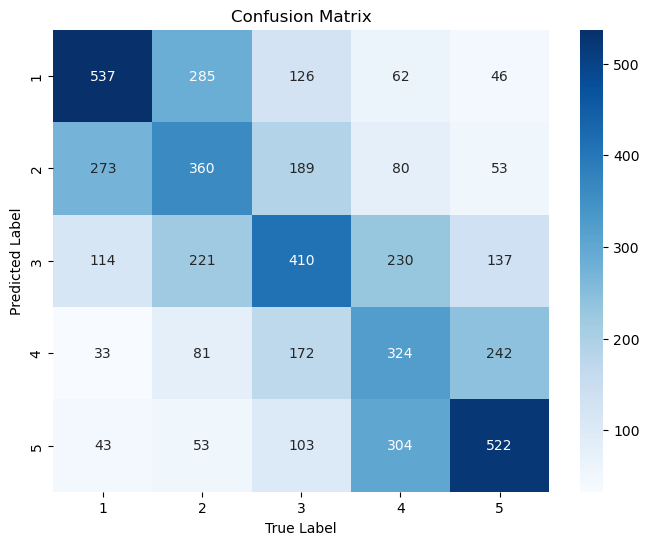

In [111]:
preds, labels = evaluate_model(model, test_loader, [1,2,3,4,5])

In [119]:
# Define a simple neural network model
class customMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(customMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [199]:
# train an MLP for comparison
# Initialize model
input_size = X_train_combined.shape[1]
# num_classes = 5
num_classes = 5
model_MLP = customMLP(input_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
optimizer = optim.Adam(model_MLP.parameters(), lr=0.0001)

# Train model
train_model(model_MLP, train_loader, test_loader, criterion, optimizer, epochs=25)

Epoch 1/25, Loss: 1.436149302482605
Epoch 1/25, Val Loss: 1.746775267791748
Epoch 2/25, Loss: 1.1849642618179321
Epoch 2/25, Val Loss: 1.483864900302887
Epoch 3/25, Loss: 1.1116943690299987
Epoch 3/25, Val Loss: 1.4074874208450316
Epoch 4/25, Loss: 1.0467588098526002
Epoch 4/25, Val Loss: 1.3402749164581298
Epoch 5/25, Loss: 0.9827305965423584
Epoch 5/25, Val Loss: 1.2776882327079773
Epoch 6/25, Loss: 0.9255082864761353
Epoch 6/25, Val Loss: 1.225148013973236
Epoch 7/25, Loss: 0.8758837864875794
Epoch 7/25, Val Loss: 1.1839380138397217
Epoch 8/25, Loss: 0.830297207069397
Epoch 8/25, Val Loss: 1.147197132873535
Epoch 9/25, Loss: 0.7885347069263459
Epoch 9/25, Val Loss: 1.115129910326004
Epoch 10/25, Loss: 0.7484090889453888
Epoch 10/25, Val Loss: 1.08565938038826
Epoch 11/25, Loss: 0.7090987055301666
Epoch 11/25, Val Loss: 1.059561684179306
Epoch 12/25, Loss: 0.6716117166042328
Epoch 12/25, Val Loss: 1.0345543337345122
Epoch 13/25, Loss: 0.6346119675159454
Epoch 13/25, Val Loss: 1.01225

Test Accuracy: 0.4268
Top-1 Error: 57.32%, Top-2 Error: 28.60%


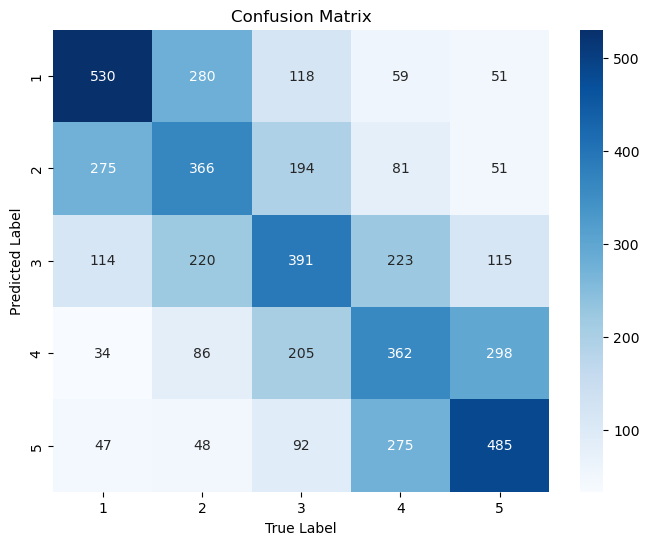

In [201]:
preds, labels = evaluate_model(model_MLP, test_loader, [1,2,3,4,5])

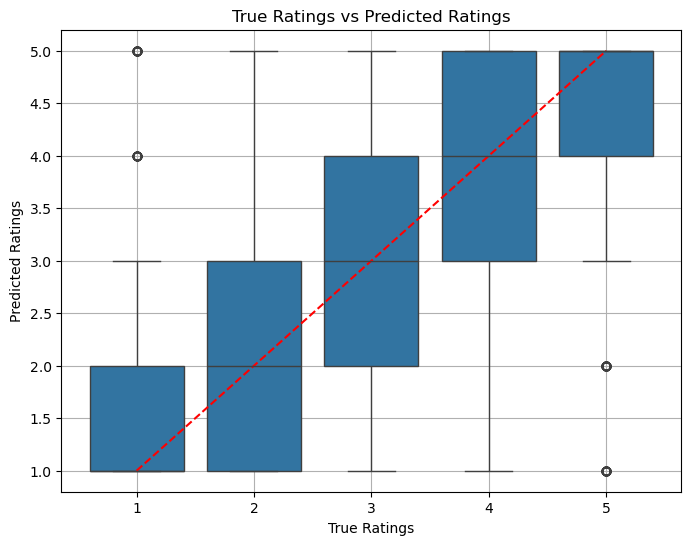

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting True vs Predicted Ratings
plt.figure(figsize=(8, 6))
sns.boxplot(x=labels, y=preds)
plt.plot([0, 4], [1, 5], color='red', linestyle='--')  # Ideal prediction line (y = x)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True Ratings vs Predicted Ratings')
plt.grid(True)
plt.show()